## Substrates

### Benchmark substrate potentials: different wells and symmetries

The clusters move on a rigid substrate potential.
This is defined in terms of a lattice or in terms of a superposition of plane waves (so it can also be a quasi-crystal).

For plane waves, the number and realtive phase of waves controls the symmetry and a parameter $\epsilon$ the amplitude.

In case of a lattice, the repeated unit, or \textit{well}, can be an arbitrary function.
We do not put any restriction on it, but one would usually assume the substrate is a continous function. Hence to avoid discontinuities, the well function should go to zero at the cell border.

In [1]:
# Matrices defining substrate periodicity
from tool_create_substrate import calc_matrices_triangle, calc_matrices_square, calc_matrices_bvect
# Substrate types (particles-wise functions)
from tool_create_substrate import particle_en_gaussian, particle_en_sin, particle_en_tanh
# Misc
from tool_create_substrate import gaussian, get_ks
from misc import get_brillouin_zone_2d, plot_BZ2d, plot_UC

### Lattice substrate

Define the susbstrate as a lattice of repeated potential wells.

#### Substrate symmetry
The substrate lattice is defined giving the two primitive vectors, just like a cluster.

In [2]:
# Define the substrate lattice using vectors
### Ortho
#b1, b2, R = np.array([1,0]), np.array([0,2]), None # Ortho
#(u, u_inv), sym = calc_matrices_bvect(b1, b2), 'ortho'
### Triangle 
b1, b2, R = np.array([1,0]), np.array([1/2, -sqrt(3)/2]), None # Triangle
(u, u_inv), sym = calc_matrices_bvect(b1, b2), 'triangle'

# Shortcut for common lattice (R is lattice spacing)
# R = 1
# Triangle (shortcut)
# (u, u_inv), sym = calc_matrices_triangle(R), ' triangle'

# Square (shortcut)
# (u, u_inv), sym = calc_matrices_square(R), ' square'

#### Basis
The Bravais lattice of the substrate can be decorated with a basis

In [3]:
basis = [np.array([0,0])] # Simple lattice

# Decorated lattice examples
# basis = [[0,0], [0.6, 1]]
# basis = [[0,0], [0.5, 0.75]]
# basis = [[0,0], [0.5, 1.5]]

####  Well shape
This is the functino repeated at each lattice point

In [4]:
# Select according to below: Gauss, Tanh, LJ // Sin to swi
sub_type = 'Sin'

###### Gauss
See Xin Cao, Andrea Silva, Emanuele Panizon, Andrea Vanossi, Nicola Manini, Erio Tosatti, and Clemens Bechinger
Phys. Rev. X 12, 021059 (2022)

In [5]:
if sub_type == 'Gauss':
    print('Gaussian substrate')
    title = 'Gauss well - Sym: %s' % sym
    R, epsilon, sigma, a, b = 1, 1, 0.1, 0.2, 0.45
    en_inputs = [basis, a, b, sigma, epsilon, u, u_inv]
    en_func = particle_en_gaussian

###### Tanh
See Xin Cao, Emanuele Panizon, Andrea Vanossi, Nicola Manini, Erio Tosatti, and Clemens Bechinger
Phys. Rev. E 103, 012606 (2021)

In [6]:
if sub_type == 'Tanh':
    print('Tanh substrate')
    title = 'Tanh well - Sym: %s' % sym
    epsilon, ww, a, b = 1, 0.25, 0.1, 0.45
    #epsilon, ww, a, b = 1, 0.1, 0.1, 0.45
    en_inputs = [basis, a, b, ww, epsilon, u, u_inv]
    en_func = particle_en_tanh

### Plane wave substrate

See Vanossi, Manini, Tosatti, PNAS  9 109 16429–16433 (2012)

In [7]:
if sub_type == 'Sin':
    print('Sin substrate')
    # Substrate params
    R, epsilon = 1, 1
    # Define symmetry of substrate (number of PW and phase)
    #n, c_n, alpha_n = 2, 1, 0 # Lines
    n, c_n, alpha_n = 3, 4/3, 0 # Tri
    #n, c_n, alpha_n = 4, np.sqrt(2), pi/4 # Square
    #n, c_n, alpha_n = 5, 2, 0 # Qausi-cristal
    #n, c_n, alpha_n = 6, 4/np.sqrt(3), -pi/6
    ks = get_ks(R, n, c_n, alpha_n) # Get the reciprocal vectors defined by the coefficients above
    
    title = 'Sin - sym n=%i' % n 
    
    en_inputs = [basis, ks, epsilon]
    en_func = particle_en_sin

Sin substrate


### Plot

In [8]:
# Matrix describing the lattice: S[0] first vector, S[1] second
if sub_type == 'Sin':
    print("Sin potential: no matrix S, u, u_inv")
    S = np.array([[0,0], [R,0]]) # Migtht not be well defined, q-crystals
else:
    print("Gauss/Tanh/LJ potential: use S, u, u_inv")
    S = u_inv.T

Sin potential: no matrix S, u, u_inv


#### Grid and compute energetics

Let's look at a portion of this infinite substrate.
Define a grid in real space, and

In [9]:
x0, x1, nx = -2, 2, 150
y0, y1, ny = -2, 2, 150
xx, yy = np.meshgrid(np.linspace(x0, x1, nx), np.linspace(y0, y1, ny))
# I am a physics not a computer scientist, so I don't like this meshgrid format.
# I want N points in two dimension, so N x 2
pp = np.stack([xx, yy], axis=2)
p = np.reshape(pp, (pp.shape[0]*pp.shape[1], 2))

en, F, tau = en_func(p, [0,0], *en_inputs)

# x line
xyline = np.stack([np.linspace(0, x1/2, 2*nx), np.zeros(2*nx)], axis=1)
# skwed line
#xyline = np.stack([np.linspace(0, x1, nx), 0.5*np.linspace(0, y1, ny)], axis=1)
tline = np.linspace(0, 1, len(xyline))
enl, Fl, taul = en_func(xyline, [0,0], *en_inputs)

In [10]:
def plot_UC(ax, u, params={'ls': '--', 'color': 'tab:gray', 'lw': 1}):
    """Shortcut to plot the Brillouin zone of the lattice"""
    BZ_corner = np.array([(n*u[0]+m*u[1])
                          for n,m in [[0,0], [1,0], [1,1], [0,1], [0,0]]
                         ])
    for i in range(4):
        ax.plot([BZ_corner[i+1,0], BZ_corner[i,0]],
                [BZ_corner[i+1,1], BZ_corner[i,1]], **params)
    return ax

#### 2D maps

First plot the energy density, the two components of the force density field.

We can also plot the torque density field with repsect to the origin. Just remember that for an infinite layer like this it makes not so much sense.

In [ ]:
fig, ((axE, axFx), (axFy, axtau)) = plt.subplots(2,2, dpi=200, sharex=True, sharey=True, figsize=(8,6))
fig.suptitle(title)
ws_params = {'ls': '--', 'color': 'tab:gray', 'lw': 1, 'fill': False}
s0 = 1

# Energy
sc = axE.scatter(p[:,0], p[:,1], c=en, s=s0)
plt.colorbar(sc, label=r'$E(x,y)$', ax=axE)
axE.plot(xyline[:,0], xyline[:,1], '--', color='black', label='$t$ line')
if sub_type != 'Sin': plot_BZ2d(axE, get_brillouin_zone_2d(S), ws_params)
axE.quiver(0, 0, *S[0], angles='xy', scale_units='xy', scale=1, zorder=5, color='red', label='b1')
axE.quiver(0, 0, *S[1], angles='xy', scale_units='xy', scale=1, zorder=5, color='orange', label='b2')
axE.legend()
axE.set_xlim([x0, x1])
axE.set_ylim([y0, y1])
axE.set_ylabel('y')
axE.set_aspect('equal')
#-------------------------

# Force along x
sc = axFx.scatter(p[:,0], p[:,1], c=F[:,0], s=s0, cmap='PiYG')
plt.colorbar(sc, label=r'$F_x(x,y)$', ax=axFx)
axFx.plot(xyline[:,0], xyline[:,1], '--', color='black')
if sub_type != 'Sin': plot_BZ2d(axFx, get_brillouin_zone_2d(S), ws_params)
axFx.set_xlim([x0, x1])
axFx.set_ylim([y0, y1])
axFx.set_aspect('equal')
#-------------------------

# Force along y
sc = axFy.scatter(p[:,0], p[:,1], c=F[:,1], s=s0, cmap='PiYG')
plt.colorbar(sc, label=r'$F_y(x,y)$', ax=axFy)
axFy.plot(xyline[:,0], xyline[:,1], '--', color='black')
if sub_type != 'Sin': plot_BZ2d(axFy, get_brillouin_zone_2d(S), ws_params)
axFy.set_xlim([x0, x1])
axFy.set_ylim([y0, y1])
axFy.set_xlabel('x')
axFy.set_ylabel('y')
axFy.set_aspect('equal')
#-------------------------

# Torque
sc = axtau.scatter(p[:,0], p[:,1], c=tau, s=s0, cmap='RdBu')
plt.colorbar(sc, label=r'$\tau(x,y)$', ax=axtau)
axtau.plot(xyline[:,0], xyline[:,1], '--', color='black')
if sub_type != 'Sin': plot_BZ2d(axtau, get_brillouin_zone_2d(S), ws_params)
axtau.set_xlim([x0, x1])
axtau.set_ylim([y0, y1])
axtau.set_xlabel('x')
axtau.set_aspect('equal')
#-------------------------

plt.tight_layout()
plt.show()

#### 1D lines
The same quantities above along the black dashed line

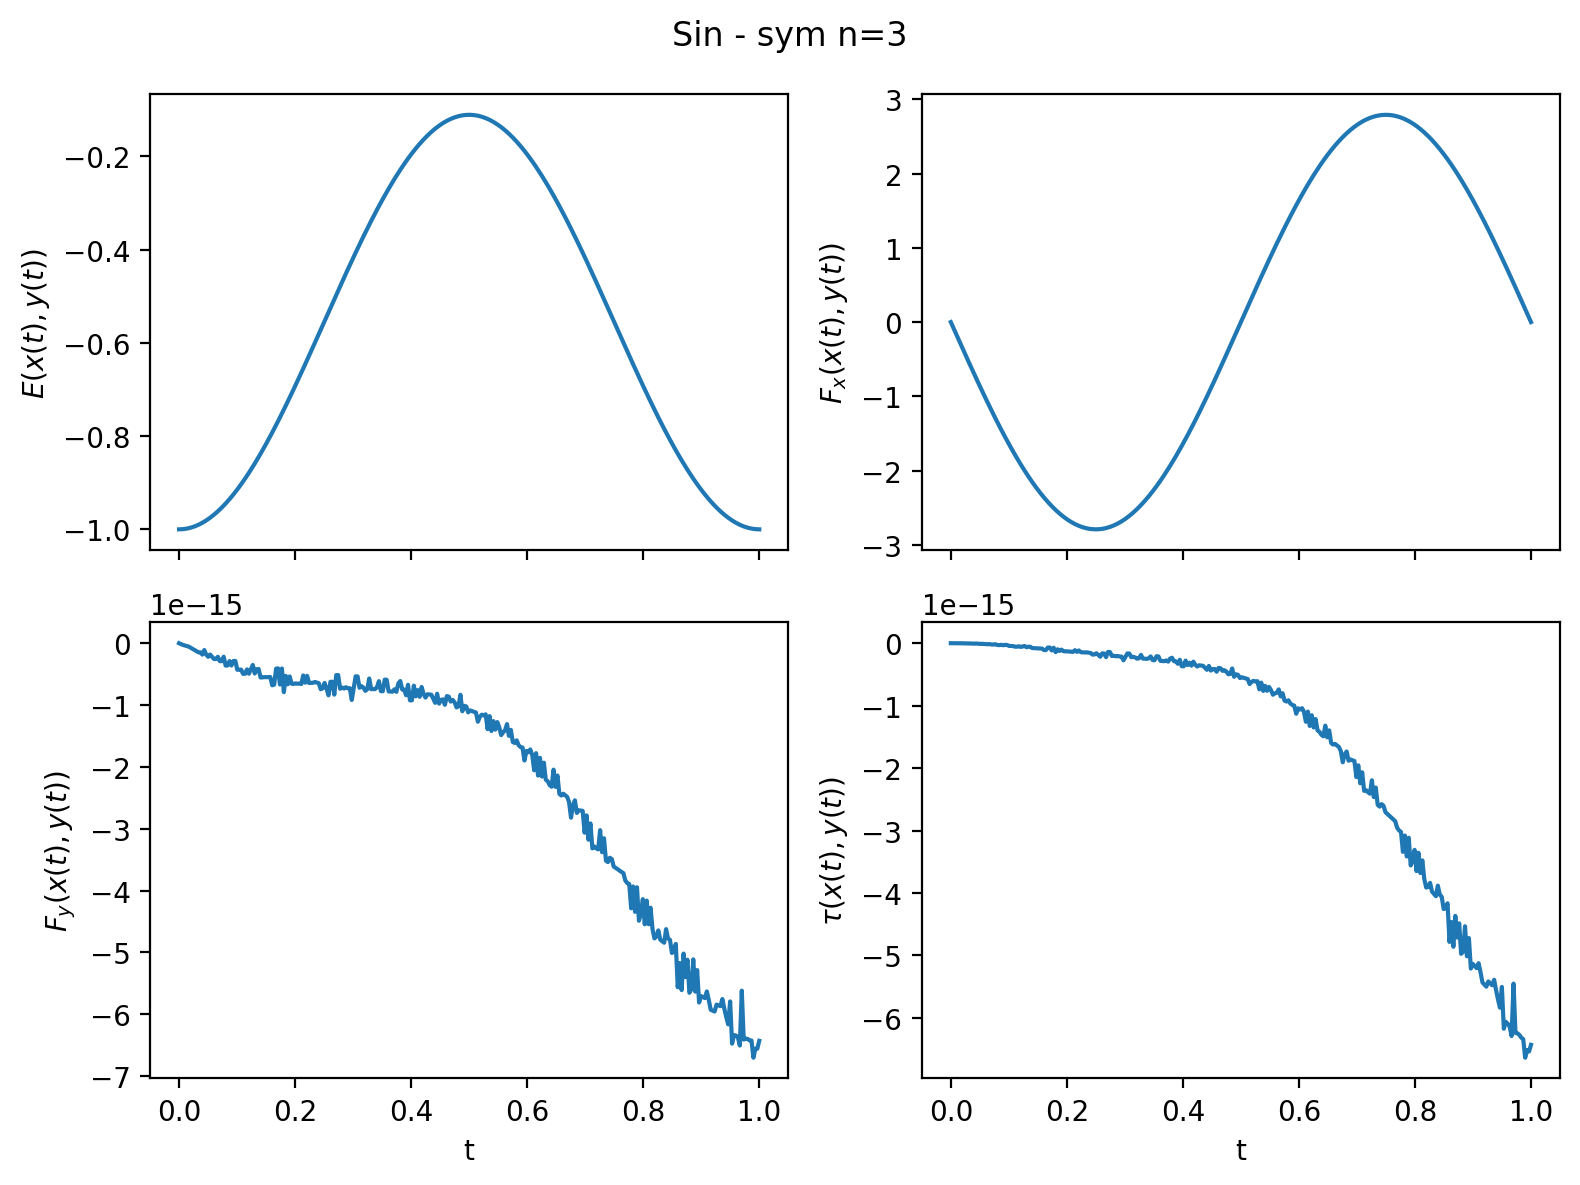

In [12]:
fig, ((axE, axFx), (axFy, axtau)) = plt.subplots(2,2, dpi=200, sharex=True, sharey=False, figsize=(8,6))
fig.suptitle(title)

axE.plot(tline, enl)
axE.set_ylabel(r'$E(x(t), y(t))$')

axFx.plot(tline, Fl[:,0])
axFx.set_ylabel(r'$F_x(x(t), y(t))$')

axFy.plot(tline, Fl[:,1])
axFy.set_ylabel(r'$F_y(x(t), y(t))$')
axFy.set_xlabel('t')

axtau.plot(tline, taul)
axtau.set_ylabel(r'$\tau(x(t), y(t))$')
axtau.set_xlabel('t')

plt.tight_layout()
plt.show()

#### Init from param

You can define the substrate potential simply by putting the parameters in a dictionary and loading it with the ```substrate_from_params``` function.
It returns the right per particle and total energy functions, along with the right parameters.

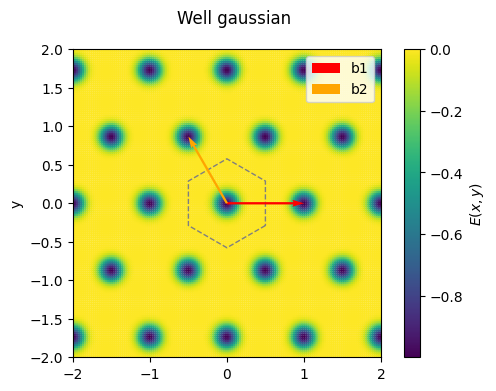

In [13]:
from tool_create_substrate import substrate_from_params

# Define symmetry of substrate
#n, c_n, alpha_n = 2, 1, 0 # Lines
n, c_n, alpha_n = 3, 4/3, 0 # Tri
# n, c_n, alpha_n = 4, np.sqrt(2), pi/4 # Square
# n, c_n, alpha_n = 5, 2, 0 # Qausi-cristal
#n, c_n, alpha_n = 6, 4/np.sqrt(3), -pi/6
R = 1
ks = get_ks(R, n, c_n, alpha_n) # Get the reciprocal vectors defined  che coefficients above

params = {
    'sub_basis': [[0,0]],
    'b1': [1,0],
    'b2': [-1/2, sqrt(3)/2],
    #'b2': [0,1],
    'epsilon': 1,
    #------ Gaussian
    'well_shape': 'gaussian',
    'sigma': 0.1, 'a': 0.3, 'b': 0.45,
    #------ LJ
    #'well_shape': 'lj',
    #'sigma': 0.1, 'd0': 0.11224620483093731, 'a': 0.1, 'b': 0.45,
    #------ Tanh
    #'well_shape': 'tanh',
    'wd': 0.25, 'a': 0.1, 'b': 0.45,
    #------ Sin
    #'well_shape': 'sin',
    'ks': ks
}

pen_func, en_func, en_inputs = substrate_from_params(params)
side = 2
x0, x1, nx = -side, side, 150
y0, y1, ny = -side, side, 150
xx, yy = np.meshgrid(np.linspace(x0, x1, nx), np.linspace(y0, y1, ny))
pp = np.stack([xx, yy], axis=2)
p = np.reshape(pp, (pp.shape[0]*pp.shape[1], 2))

en, F, tau = pen_func(p, [0,0], *en_inputs)

fig, axE = plt.subplots(1,1, dpi=100, sharex=True, sharey=True, figsize=(6,4))
fig.suptitle('Well %s' % params['well_shape'])
s0 = 1

# Energy
sc = axE.scatter(p[:,0], p[:,1], c=en, s=s0)
plt.colorbar(sc, label=r'$E(x,y)$', ax=axE)
_, u_inv = calc_matrices_bvect(params['b1'], params['b2'])
S = u_inv.T
if params['well_shape'] != 'sin': plot_BZ2d(axE, get_brillouin_zone_2d(S), ws_params)
axE.quiver(0, 0, *S[0], angles='xy', scale_units='xy', scale=1, zorder=5, color='red', label='b1')
axE.quiver(0, 0, *S[1], angles='xy', scale_units='xy', scale=1, zorder=5, color='orange', label='b2')
axE.legend(loc='upper right')
axE.set_xlim([x0, x1])
axE.set_ylim([y0, y1])
axE.set_ylabel('y')
axE.set_aspect('equal')
#-------------------------